# Analyse syntax sketches

In [1]:
import os, os.path
import conllu
from statistics import median
from collections import Counter, OrderedDict

from numpy import argmax 
from numpy import arange
from numpy import array
from numpy import cumsum
from numpy import quantile
from pandas import DataFrame

import matplotlib.pyplot as plt

from estnltk.converters.conll.conll_importer import conll_to_text

from syntax_sketches.syntax_sketch import clean_clause
from syntax_sketches.syntax_sketch import syntax_sketch

In [2]:
# Configuration
# Input directory (must contain conllu files with sentences split into clauses)
input_dir = 'edt_2.6\\preannotated\\morph_extended_clauses'
assert os.path.isdir(input_dir)
remove_empty_nodes = True # remove empty nodes from input conllu files

# Save top 50 sketches for knock-out experiments into this file
knockout_list_file = 'edt_2.6\\preannotated\\morph_extended_clauses\\knock_out_list.csv'

## I. Load data

In [3]:
whole_data = list()
for fname in os.listdir(input_dir):
    if fname.endswith('.conllu'):
        print(fname)
        text_obj = conll_to_text(os.path.join(input_dir, fname), 'ud_syntax', remove_empty_nodes=remove_empty_nodes)
        text_obj.meta['file'] = fname
        # Rename sentences layer 
        # (because it actually contains clauses, not sentences)
        clauses_layer = text_obj.pop_layer('sentences')
        clauses_layer.name = 'clauses'
        text_obj.add_layer(clauses_layer)
        whole_data.append(text_obj)

et_edt-ud-dev-morph_extended.conllu
et_edt-ud-test-morph_extended.conllu
et_edt-ud-train-morph_extended.conllu


## II. Compute syntax sketches for clauses

In [4]:
clauses_count_total = 0
invalid_clauses_total = 0
expected_layers = {'clauses', 'ud_syntax', 'words'}

sketches = list()
for text in whole_data:
    clauses_count = 0
    assert text.layers == expected_layers, f'Unexpected layers {text.layers!r}'

    for clause in text.clauses:
        cleaned_clause = clean_clause(clause)
        if len(cleaned_clause['root_loc']) != 1:
            invalid_clauses_total += 1
            continue
        sketches.append(syntax_sketch(cleaned_clause))
        clauses_count += 1
    print(text_obj.meta['file'], '|', '#clauses:   {}'.format(clauses_count))
    clauses_count_total += clauses_count

print()
print('#clauses total:   {}'.format(clauses_count_total))
if invalid_clauses_total > 0:
    print('#invalid clauses total:   {}'.format(invalid_clauses_total))

et_edt-ud-train-morph_extended.conllu | #clauses:   5708
et_edt-ud-train-morph_extended.conllu | #clauses:   6033
et_edt-ud-train-morph_extended.conllu | #clauses:   43966

#clauses total:   55707


## III. Analyse distribution of syntax sketches

In [5]:
sketch_counter = Counter(sketches)
print('Number of valid clauses:      {}'.format(clauses_count_total))
print('Number of different sketches: {}'.format(len(sketch_counter)))
print('Expected sketch support:      {:.2f}'.format(clauses_count_total/len(sketch_counter)))
print('Median sketch support:        {:.2f}'.format(median(sketch_counter.values())))
print('Non-singleton sketches:      {:.2f}%'.format(sum(array(list(sketch_counter.values())) > 1)/len(sketch_counter.values()) * 100))

Number of valid clauses:      55707
Number of different sketches: 7925
Expected sketch support:      7.03
Median sketch support:        1.00
Non-singleton sketches:      37.49%


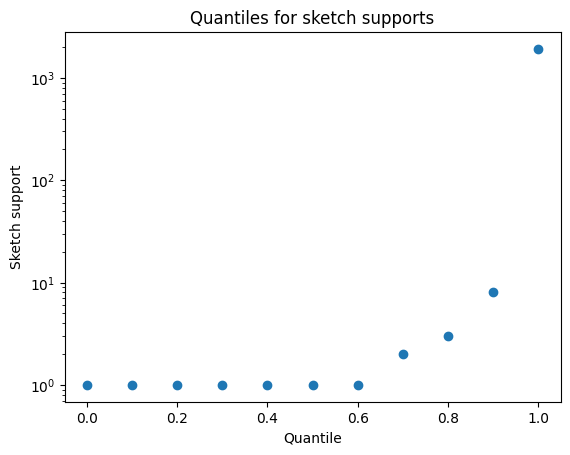

In [6]:
qtls = arange(0, 1.1, 0.1)
plt.scatter(x=qtls, y=quantile(list(sketch_counter.values()),q=qtls))
plt.title('Quantiles for sketch supports')
plt.xlabel('Quantile')
plt.ylabel('Sketch support')
plt.yscale('log')
plt.show()

In [7]:
display(DataFrame({
    'Top sketches': [sketch for sketch, _ in sketch_counter.most_common(50)],
    'Support': [count for _, count in sketch_counter.most_common(50)] 
}))

,Top sketches,Support
0,[V]nsubj(L),1918
1,[S],1891
2,[V]nsubj(L)obl(L),979
3,[V],883
4,[S]cop(L)nsubj:cop(L),853
5,[V]nsubj(L)obj(L),760
6,[V]advmod(L)nsubj(L),663
7,[V]obj(L),594
8,[V]obl(L),557
9,[V]nsubj(L)obj(L)obl(L),534


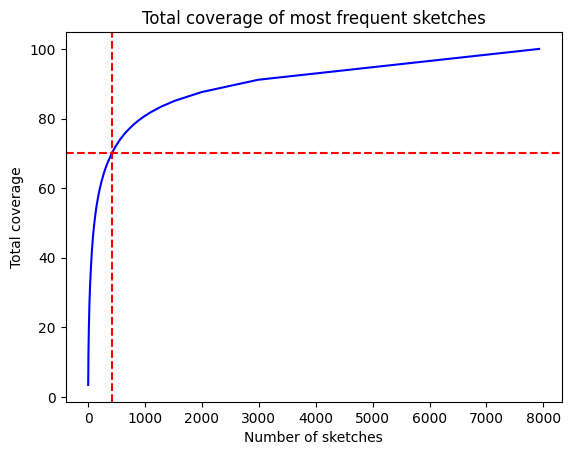

In [8]:
coverage = cumsum(sorted(list(sketch_counter.values()), reverse=True))
coverage = coverage/coverage[-1] * 100

plt.plot(range(1, len(coverage)+1), coverage, color='blue')
plt.axhline(y=70, color='r', linestyle='--')
plt.axvline(x=argmax(coverage >= 70) + 1, color='r', linestyle='--')
plt.title('Total coverage of most frequent sketches')
plt.xlabel('Number of sketches')
plt.ylabel('Total coverage')
plt.show()

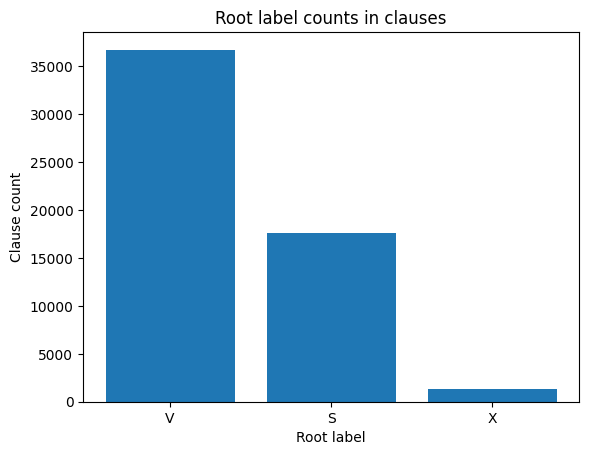

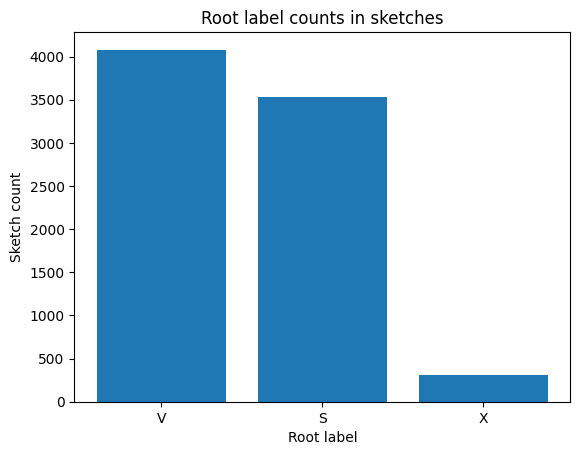

In [9]:
root_counts = dict()
for sketch, count in sketch_counter.items():
    root_counts[sketch[1]] = root_counts.get(sketch[1], 0) + count

plt.bar(range(len(root_counts)), list(root_counts.values()), align='center')
plt.xticks(range(len(root_counts)), list(root_counts.keys()))
plt.title('Root label counts in clauses')
plt.xlabel('Root label')
plt.ylabel('Clause count')
plt.show()

root_counts = dict()
for sketch, count in sketch_counter.items():
    root_counts[sketch[1]] = root_counts.get(sketch[1], 0) + 1
    
plt.bar(range(len(root_counts)), list(root_counts.values()), align='center')
plt.xticks(range(len(root_counts)), list(root_counts.keys()))
plt.title('Root label counts in sketches')
plt.xlabel('Root label')
plt.ylabel('Sketch count')
plt.show()

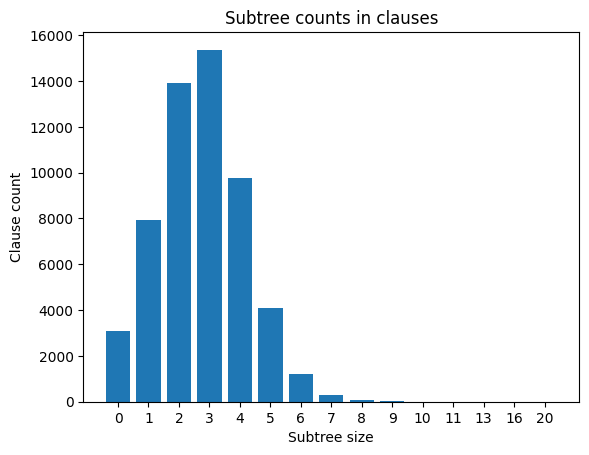

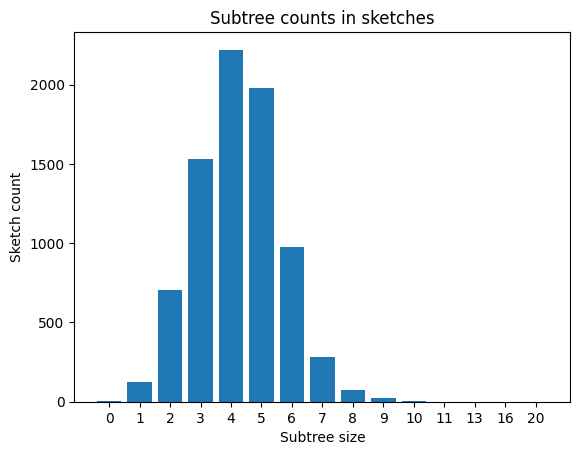

In [10]:
subtree_counts = dict()
for sketch, count in sketch_counter.items():
    subtree_count = sketch.count(')')
    subtree_counts[subtree_count] = subtree_counts.get(subtree_count, 0) + count
subtree_counts = dict(sorted(subtree_counts.items()))    

plt.bar(range(len(subtree_counts)), list(subtree_counts.values()), align='center')
plt.xticks(range(len(subtree_counts)), list(subtree_counts.keys()))
plt.title('Subtree counts in clauses')
plt.xlabel('Subtree size')
plt.ylabel('Clause count')
plt.show() 

subtree_counts = dict()
for sketch, count in sketch_counter.items():
    subtree_count = sketch.count(')')
    subtree_counts[subtree_count] = subtree_counts.get(subtree_count, 0) + 1
subtree_counts = dict(sorted(subtree_counts.items()))    


plt.bar(range(len(subtree_counts)), list(subtree_counts.values()), align='center')
plt.xticks(range(len(subtree_counts)), list(subtree_counts.keys()))
plt.title('Subtree counts in sketches')
plt.xlabel('Subtree size')
plt.ylabel('Sketch count')
plt.show() 

## IV. Save top 50 sketches for knock-out experiments

In [11]:
DataFrame({
    'sketch': [sketch for sketch, _ in sketch_counter.most_common(50)],
    'support': [count for _, count in sketch_counter.most_common(50)] 
}).to_csv( knockout_list_file )